In [1]:
# --- 1. SETUP & IMPORTS ---
import numpy as np
import os
from PIL import Image, ImageFilter, ImageEnhance
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model # For inference

In [10]:
# --- 2. GLOBAL CONFIGURATION ---

# Set up paths and classes (CRITICAL: Adjust 'D:\\ml_projects\\pothole' to your actual project root)
path = 'D:\\ml_projects\\pothole' 
base_path = os.path.join(path, "pothole_extract")
IMG_SHAPE = 299
channels = 3
training_classes = ['potholes', 'normal', 'manhole'] 


In [8]:
import os
import re

# CRITICAL: Define the exact folder path for your manhole images
manhole_folder_path = r'D:\ml_projects\pothole\pothole_extract\manhole'

# List of identifiers to delete (case-insensitive search for these strings anywhere in the name)
# This covers original files (open195.jpg) and all augmented versions (open195blur.jpg)
# I've converted your list to a clean set of identifiers for the regex.
identifiers_to_delete = [
    "open195", "open192", "open194", "open158", "open153", "open150", 
    "open147", "open143", "open135", "open129", "open126", "open114", 
    "open118", "open112", "open103", "open99", "open46", "open38", 
    "open24", "close86","close157"
]

# Create a single regular expression pattern for efficient and precise matching
# The pattern joins all identifiers with '|' (OR).
# We search for the pattern anywhere in the filename, which is necessary to catch augmented files (e.g., open195rot90.jpg).
delete_pattern = re.compile('|'.join(re.escape(name) for name in identifiers_to_delete), re.IGNORECASE)

deleted_count = 0
if os.path.isdir(manhole_folder_path):
    print(f"Starting precise cleanup of corrupt/cartoon files in: {manhole_folder_path}")
    
    # Change directory to easily work with filenames
    os.chdir(manhole_folder_path)
    
    for filename in os.listdir('.'):
        # Check if the filename contains any of the specified identifiers
        if delete_pattern.search(filename):
            full_file_path = os.path.join(manhole_folder_path, filename)
            
            try:
                os.remove(full_file_path)
                print(f"DELETED: {filename}")
                deleted_count += 1
            except Exception as e:
                print(f"Error deleting {filename}: {e}")
                
    print(f"\nCleanup complete. Total files deleted: {deleted_count}")
    
else:
    print(f"Error: Directory not found at {manhole_folder_path}")

Starting precise cleanup of corrupt/cartoon files in: D:\ml_projects\pothole\pothole_extract\manhole
DELETED: m-close157.jpg
DELETED: m-close157blur.jpg
DELETED: m-close157Brightness.jpg
DELETED: m-close157rot90.jpg
DELETED: m-close86.jpg
DELETED: m-close86blur.jpg
DELETED: m-close86Brightness.jpg
DELETED: m-close86rot90.jpg

Cleanup complete. Total files deleted: 8


Final Distribution

image counts:{'potholes': 1316, 'normal': 1408, 'manhole': 1296}


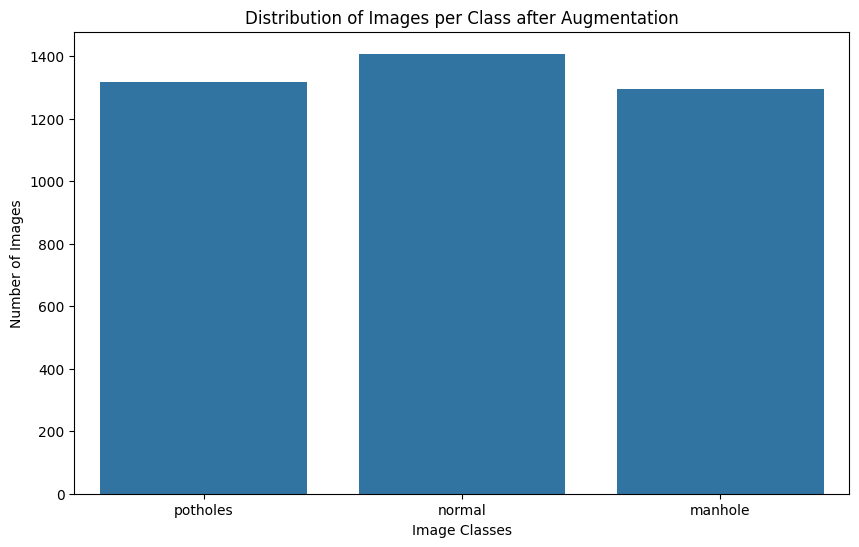

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get the counts of images in each class
image_counts = {}
path = r'D:\ml_projects\pothole\pothole_extract' # Assuming path is still the base directory for images

for names in training_classes:
    folder_path = os.path.join(path, names)
    count = 0
    if os.path.isdir(folder_path):
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            if os.path.isfile(item_path):
                count += 1
    image_counts[names] = count
    
print(f'image counts:{image_counts}')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))
plt.xlabel("Image Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class after Augmentation")
plt.show()

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Correctly set the path to the root of your project
# This should be the directory that contains the 'pothole_extract' folder
path = 'D:\\ml_projects\\pothole'
base_path = os.path.join(path, "pothole_extract")

# Define the image shape and channels
IMG_SHAPE = 299
channels = 3

# Create lists to hold valid data
train_images_list = []
train_labels_list = []
val_images_list = []
val_labels_list = []

# Assuming img_label is already populated
img_label = {}
for class_name in ['potholes', 'normal', 'manhole']:
    folder_path = os.path.join(base_path, class_name)
    if os.path.isdir(folder_path):
        os.chdir(folder_path)
        for image_name in os.listdir('.'):
            if image_name.lower().endswith('.jpg'):
                if 'potholes' in class_name:
                    # Pothole -> [1, 0, 0]
                    img_label[image_name] = np.asarray([1, 0, 0], dtype=np.float32)
                elif 'manhole' in class_name:
                    # Manhole -> [0, 1, 0]
                    img_label[image_name] = np.asarray([0, 1, 0], dtype=np.float32)
                else:
                    # Normal -> [0, 0, 1]
                    img_label[image_name] = np.asarray([0, 0, 1], dtype=np.float32)
os.chdir(path)

# Perform the train/test split
img_name_train, img_name_val, output_label_train, output_label_val = train_test_split(
    list(img_label.keys()),
    list(img_label.values()),
    test_size=0.1,
    random_state=0
)

In [21]:
img_label

{'p-1.jpg': array([1., 0., 0.], dtype=float32),
 'p-10.jpg': array([1., 0., 0.], dtype=float32),
 'p-100.jpg': array([1., 0., 0.], dtype=float32),
 'p-100blur.jpg': array([1., 0., 0.], dtype=float32),
 'p-100Brightness.jpg': array([1., 0., 0.], dtype=float32),
 'p-100rot90.jpg': array([1., 0., 0.], dtype=float32),
 'p-101.jpg': array([1., 0., 0.], dtype=float32),
 'p-101blur.jpg': array([1., 0., 0.], dtype=float32),
 'p-101Brightness.jpg': array([1., 0., 0.], dtype=float32),
 'p-101rot90.jpg': array([1., 0., 0.], dtype=float32),
 'p-102.jpg': array([1., 0., 0.], dtype=float32),
 'p-102blur.jpg': array([1., 0., 0.], dtype=float32),
 'p-102Brightness.jpg': array([1., 0., 0.], dtype=float32),
 'p-102rot90.jpg': array([1., 0., 0.], dtype=float32),
 'p-103.jpg': array([1., 0., 0.], dtype=float32),
 'p-103blur.jpg': array([1., 0., 0.], dtype=float32),
 'p-103Brightness.jpg': array([1., 0., 0.], dtype=float32),
 'p-103rot90.jpg': array([1., 0., 0.], dtype=float32),
 'p-104.jpg': array([1., 0.

In [26]:
def load_and_preprocess_images(image_names, labels, images_list, labels_list, desc):
    """
    Loads, preprocesses, and appends images and labels to lists with robust error handling.
    """
    for i, image_name in enumerate(tqdm(image_names, desc=desc)):
        if image_name.lower().startswith('p'):
            folder = 'potholes'
        elif image_name.lower().startswith('m'):
            folder = 'manhole' # The manhole folder name
        elif image_name.lower().startswith('n'):
            folder = 'normal'
        else:
            print(f"Skipping image {image_name}: Prefix not found.")
            continue
        
        full_path = os.path.join(base_path, folder, image_name)
        
        try:
            img_raw = tf.io.read_file(full_path)
            img = tf.image.decode_jpeg(img_raw, channels=3)
            img = tf.image.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img = img / 255.0
            
            images_list.append(img)
            labels_list.append(labels[i])
        except (tf.errors.NotFoundError, tf.errors.InvalidArgumentError) as e:
            print(f"Skipping image {image_name}: {e}")
        except Exception as e:
            print(f"Skipping image {image_name} due to an unexpected error: {e}")

In [27]:
load_and_preprocess_images(img_name_train, output_label_train, train_images_list, train_labels_list, "Loading Training Data")
load_and_preprocess_images(img_name_val, output_label_val, val_images_list, val_labels_list, "Loading Validation Data")

train_images = np.array(train_images_list)
train_labels = np.array(train_labels_list)
val_images = np.array(val_images_list)
val_labels = np.array(val_labels_list)

print("Image arrays created successfully!")
print(f"Shape of train_images: {train_images.shape}")
print(f"Shape of train_labels: {train_labels.shape}")
print(f"Shape of val_images: {val_images.shape}")
print(f"Shape of val_labels: {val_labels.shape}")

Loading Training Data:   1%|          | 30/3618 [00:00<00:39, 91.23it/s]

Skipping image p-190.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:   4%|▎         | 129/3618 [00:01<00:43, 79.34it/s]

Skipping image p-151.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:   4%|▍         | 154/3618 [00:01<00:49, 70.27it/s]

Skipping image n-pothole_extract86.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:   7%|▋         | 260/3618 [00:03<00:41, 81.10it/s]

Skipping image p-191.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:   8%|▊         | 294/3618 [00:03<00:46, 72.11it/s]

Skipping image n-pothole_extract201.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  12%|█▏        | 434/3618 [00:05<00:47, 66.77it/s]

Skipping image n-pothole_extract65.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  29%|██▉       | 1053/3618 [00:14<00:31, 80.39it/s]

Skipping image n-pothole_extract115.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  31%|███       | 1115/3618 [00:15<00:29, 85.45it/s]

Skipping image p-273.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  33%|███▎      | 1180/3618 [00:16<00:29, 82.29it/s]

Skipping image n-pothole_extract109.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  39%|███▉      | 1419/3618 [00:18<00:26, 83.97it/s]

Skipping image n-pothole_extract210.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  48%|████▊     | 1736/3618 [00:23<00:22, 84.24it/s]

Skipping image p-17.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  49%|████▉     | 1790/3618 [00:24<00:23, 79.37it/s]

Skipping image p-170.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  51%|█████▏    | 1863/3618 [00:25<00:20, 84.36it/s]

Skipping image n-pothole_extract298.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  55%|█████▍    | 1978/3618 [00:26<00:18, 87.45it/s]

Skipping image p-320.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  58%|█████▊    | 2102/3618 [00:27<00:17, 88.01it/s]

Skipping image n-pothole_extract303.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  61%|██████    | 2209/3618 [00:29<00:16, 83.44it/s]

Skipping image p-182.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  62%|██████▏   | 2258/3618 [00:29<00:17, 79.15it/s]

Skipping image p-41.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  70%|██████▉   | 2532/3618 [00:33<00:11, 92.41it/s]

Skipping image n-pothole_extract189.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  73%|███████▎  | 2640/3618 [00:34<00:12, 80.31it/s]

Skipping image n-pothole_extract62.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  76%|███████▌  | 2755/3618 [00:35<00:09, 92.07it/s]

Skipping image n-pothole_extract238.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  84%|████████▍ | 3044/3618 [00:40<00:07, 73.16it/s]

Skipping image p-106.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Training Data:  87%|████████▋ | 3151/3618 [00:41<00:05, 82.90it/s]

Skipping image p-312rot90.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input is empty. [Op:DecodeJpeg]


Loading Training Data:  90%|█████████ | 3271/3618 [00:43<00:04, 82.95it/s]

Skipping image p-40.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Validation Data:  37%|███▋      | 147/402 [00:01<00:02, 85.61it/s]

Skipping image n-pothole_extract209.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Validation Data:  82%|████████▏ | 328/402 [00:03<00:00, 77.06it/s]

Skipping image p-228.jpg: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]


Loading Validation Data: 100%|██████████| 402/402 [00:04<00:00, 83.76it/s]


Image arrays created successfully!
Shape of train_images: (3595, 299, 299, 3)
Shape of train_labels: (3595, 3)
Shape of val_images: (400, 299, 299, 3)
Shape of val_labels: (400, 3)


In [28]:
train_images.shape

(3595, 299, 299, 3)

In [29]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 1. Build the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

# 2. Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# 3. Add your new custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# CRITICAL CHANGE: The final layer now has 3 neurons for 3 classes
predictions = Dense(3, activation='softmax')(x)

# 4. Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the model
adam_optimizer = Adam(learning_rate=0.00001)
model.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
# model.summary()

In [30]:
# 5. Train the model for a total of 20 epochs 
history = model.fit(
    train_images,
    train_labels,
    epochs=20, 
    batch_size=32,
    validation_data=(val_images, val_labels)
)

Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 113s 894ms/step - accuracy: 0.4764 - loss: 1.0879 - val_accuracy: 0.8350 - val_loss: 0.6034
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 98s 868ms/step - accuracy: 0.8902 - loss: 0.5089 - val_accuracy: 0.8900 - val_loss: 0.3934
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 102s 903ms/step - accuracy: 0.9241 - loss: 0.3421 - val_accuracy: 0.9175 - val_loss: 0.3093
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9450 - loss: 0.2523 - val_accuracy: 0.9225 - val_loss: 0.2752
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 99s 880ms/step - accuracy: 0.9397 - loss: 0.2227 - val_accuracy: 0.9200 - val_loss: 0.2461
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 100s 889ms/step - accuracy: 0.9517 - loss: 0.1981 - val_accuracy: 0.9250 - val_loss: 0.2277
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 3782s 34s/step - accuracy: 0.9522 - loss: 0.1769 - val_accuracy: 0.9350 - val_loss: 0.2162
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.9582 - loss: 0.

In [31]:


# --- 7. FINAL EVALUATION & SAVING ---

# Evaluate the model on the validation set
results = model.evaluate(val_images, val_labels, verbose=1)
print(f"Final Validation Loss: {results[0]:.4f}")
print(f"Final Validation Accuracy: {results[1]:.4f}")

# Save the final, best-performing model (E40 version)
model_filename = "InceptionV3_3_class_pothole_manhole_E20_LR-5.keras"
model.save(model_filename)
print(f"Model saved successfully as {model_filename}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 725ms/step - accuracy: 0.9553 - loss: 0.1483
Final Validation Loss: 0.1549
Final Validation Accuracy: 0.9475
Model saved successfully as InceptionV3_3_class_pothole_manhole_E20_LR-5.keras


## InceptionResNetV2

In [32]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# --- MODEL 2: INCEPTIONRESNETV2 BUILD AND TRAIN ---

# 1. Build the InceptionResNetV2 model
base_model_IRV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SHAPE, IMG_SHAPE, 3))

# 2. Freeze the base model's layers
for layer in base_model_IRV2.layers:
    layer.trainable = False

# 3. Add custom classification layers (3 NEURONS)
x_IRV2 = base_model_IRV2.output
x_IRV2 = GlobalAveragePooling2D()(x_IRV2)
x_IRV2 = Dense(1024, activation='relu')(x_IRV2)
predictions_IRV2 = Dense(3, activation='softmax')(x_IRV2) # Output 3 classes

# 4. Create the final model object (NOTE: unique variable name)
model_IRV2 = Model(inputs=base_model_IRV2.input, outputs=predictions_IRV2)

# 5. Compile the model with the same stable learning rate
adam_optimizer = Adam(learning_rate=0.00001)
model_IRV2.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)




219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 46s 0us/step


In [33]:
# 6. Train the model for the same duration (20 epochs)
print("Starting InceptionResNetV2 (Model 2) Training...")
history_2 = model_IRV2.fit(
    train_images,
    train_labels,
    epochs=20, 
    batch_size=32,
    validation_data=(val_images, val_labels)
)

Starting InceptionResNetV2 (Model 2) Training...
Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.5960 - loss: 0.9151 - val_accuracy: 0.8775 - val_loss: 0.5258
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9044 - loss: 0.4613 - val_accuracy: 0.9000 - val_loss: 0.3665
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 463s 4s/step - accuracy: 0.9225 - loss: 0.3335 - val_accuracy: 0.9175 - val_loss: 0.2973
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 455s 4s/step - accuracy: 0.9375 - loss: 0.2637 - val_accuracy: 0.9175 - val_loss: 0.2627
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 418s 4s/step - accuracy: 0.9373 - loss: 0.2421 - val_accuracy: 0.9225 - val_loss: 0.2408
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.9389 - loss: 0.2180 - val_accuracy: 0.9250 - val_loss: 0.2230
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 503s 4s/step - accuracy: 0.9417 - loss: 0.2076 - val_accuracy: 0.9325 - val_loss: 0.2100
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/

In [34]:
# --- FINAL EVALUATION & SAVING for InceptionResNetV2 ---

# Evaluate the model on the validation set
# Use the model variable from the InceptionResNetV2 training run (model_IRV2)
results_IRV2 = model_IRV2.evaluate(val_images, val_labels, verbose=1)
print(f"InceptionResNetV2 Final Validation Loss: {results_IRV2[0]:.4f}")
print(f"InceptionResNetV2 Final Validation Accuracy: {results_IRV2[1]:.4f}")

# Save the final, best-performing model (E20 version)
model_filename_IRV2 = "InceptionResNetV2_3_class_pothole_manhole_E20_LR-5.keras"
model_IRV2.save(model_filename_IRV2)
print(f"Model saved successfully as {model_filename_IRV2}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9451 - loss: 0.1822
InceptionResNetV2 Final Validation Loss: 0.1502
InceptionResNetV2 Final Validation Accuracy: 0.9500
Model saved successfully as InceptionResNetV2_3_class_pothole_manhole_E20_LR-5.keras


In [36]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the two trained models
model_v3 = load_model(r'D:\ml_projects\pothole\InceptionV3_3_class_pothole_manhole_E20_LR-5.keras')
model_irv2 = load_model(r'D:\ml_projects\pothole\InceptionResNetV2_3_class_pothole_manhole_E20_LR-5.keras')

# --- 1. Get Predictions ---
print("Getting predictions from both models...")
# Get the probability scores for all validation images from Model 1
probs_v3 = model_v3.predict(val_images)
# Get the probability scores for all validation images from Model 2
probs_irv2 = model_irv2.predict(val_images)

# --- 2. Implement Soft Voting (Averaging) ---
# Average the probabilities for each class
avg_probabilities = (probs_v3 + probs_irv2) / 2

# --- 3. Final Evaluation ---
# The final prediction index is the one with the highest average probability
final_predictions = np.argmax(avg_probabilities, axis=1)
true_labels = np.argmax(val_labels, axis=1) # Convert one-hot validation labels to indices

# Calculate final accuracy
ensemble_accuracy = np.mean(final_predictions == true_labels)

print(f"\n--- ENSEMBLE RESULTS ---")
print(f"InceptionV3-only accuracy: {np.mean(np.argmax(probs_v3, axis=1) == true_labels):.4f}")
print(f"InceptionResNetV2-only accuracy: {np.mean(np.argmax(probs_irv2, axis=1) == true_labels):.4f}")
print(f"Combined ENSEMBLE ACCURACY: {ensemble_accuracy:.4f} 🎉")

Getting predictions from both models...
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 814ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step

--- ENSEMBLE RESULTS ---
InceptionV3-only accuracy: 0.9475
InceptionResNetV2-only accuracy: 0.9500
Combined ENSEMBLE ACCURACY: 0.9600 🎉


Saving train Test split

In [39]:
import os
import shutil

# --- CONFIGURATION (Use the variables from your successful run) ---
# Assuming 'path' is 'D:\\ml_projects\\pothole'
# Assuming 'base_path' is 'D:\\ml_projects\\pothole\\pothole_extract'
# Assuming img_name_train and img_name_val are populated lists of filenames

# Define the new root folder for your split dataset
split_root_dir = os.path.join(path, "final_dataset_split")

# Define the full paths for the new folders
train_dir = os.path.join(split_root_dir, "train")
val_dir = os.path.join(split_root_dir, "val")

# Define the class folders inside the base_path
source_folders = {
    'p-': 'potholes',
    'm-': 'manhole',
    'n-': 'normal'
}

# --- 1. CREATE DIRECTORIES ---

# Create the main split folder and its subfolders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create class subfolders inside train/val
for prefix in source_folders:
    class_folder_name = source_folders[prefix]
    os.makedirs(os.path.join(train_dir, class_folder_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_folder_name), exist_ok=True)

print("Created new directory structure.")

# --- 2. FUNCTION TO MOVE FILES ---

def move_files(file_list, target_base_dir):
    moved_count = 0
    for filename in file_list:
        # Determine source class folder based on the prefix (p-, m-, n-)
        prefix = filename[:2].lower()
        
        if prefix in source_folders:
            class_folder = source_folders[prefix]
            
            # Construct the source path
            source_folder = os.path.join(base_path, class_folder)
            source_path = os.path.join(source_folder, filename)
            
            # Construct the destination path
            dest_folder = os.path.join(target_base_dir, class_folder)
            dest_path = os.path.join(dest_folder, filename)

            try:
                # Use copy2 to preserve file metadata (optional)
                shutil.copy2(source_path, dest_path)
                moved_count += 1
            except FileNotFoundError:
                print(f"Warning: Source file not found: {source_path}")
            except Exception as e:
                print(f"Error moving {filename}: {e}")
        
    return moved_count

# --- 3. EXECUTE THE MOVE ---

# Move Training Files
total_train_moved = move_files(img_name_train, train_dir)
print(f"Successfully copied {total_train_moved} training images to {train_dir}")

# Move Validation Files
total_val_moved = move_files(img_name_val, val_dir)
print(f"Successfully copied {total_val_moved} validation images to {val_dir}")

Created new directory structure.
Successfully copied 3618 training images to D:\ml_projects\pothole\pothole_extract\final_dataset_split\train
Successfully copied 402 validation images to D:\ml_projects\pothole\pothole_extract\final_dataset_split\val
